# MA4705 Continual Assessment

Group: DSP 50

Members: Amos Timothy Wong Jun Han (amos0018), Tan Zhi Jie (TANZ0152)

# Calculating Angles of a Suspended Body

The orientation of a still body suspended in the air can be described by the pitch, roll, and yaw. These angles are taken with reference to the axes in the North,East, and Down (NED) coordinate space. 

One method by which the orientation angles can be calculated is through the use of an accelerometer and a magnetometer that are mounted on the body. The accelerometer measures acceleration in 3 dimensional space. When it is absolutely still, the accelerometer measures gravitational acceleration or '1g' (red vector in Fig. A). The position of the axes depends on the orientation of the body (blue axes x, y, and z in Fig. A) and the accelerometer readings are the projections of the gravitational vector on these axes (green components mapped on the axes in Fig. A). On the other hand, the magnetometer points to the magnetic north. 

The orientation of the body, or its pitch, roll, and yaw are taken with reference to the North, East, and Down (NED) coordinate space as seen in Fig. B. We wish to work out the body orientation by fulfilling the following objectives.

1. Obtain the rotation/transformation matrix that will transform the NED coordinates to the current accelerometer readings with the help of the magnetometer.
2. Compute the pitch, roll, and yaw from the transformation matrix.

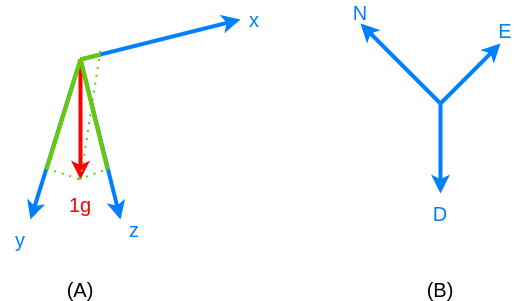


## Obtaining the Rotation matrix

Specifically, the transformation matrix rotates a vector from NED space to an Accelerometer 1g vector ($[a_{x}, a_{y}, a_{z}]^T$) as shown below.

$ 
\begin{equation}
\begin{pmatrix}
r_{00}, r_{01}, r_{02}\\
r_{10}, r_{11}, r_{12}\\
r_{20}, r_{21}, r_{22}
\end{pmatrix}
\begin{pmatrix}
n\\
e\\
d
\end{pmatrix}
=
\begin{pmatrix}
a_{x}\\
a_{y}\\
a_{z}
\end{pmatrix}
\end{equation}
$

The rotation matrix takes the following form where 'a' and 'm' refer to the accelerometer and magnetometer measurements respectively. Each measurement is a vector of 3 elements - $\bf{a} = [a_{x}, a_{y}, a_{z}]^T$ and $\bf{m} = [m_{x}, m_{y}, m_{z}]^T$. 

1. The first column from the right is the raw accelerometer reading. 
2. The second column is the cross product between vector $\bf{a}$ and $\bf{m}$.
3. The third column is the cross product between the second column and $\bf{a}$.

$ 
\begin{equation}
R = 
\begin{pmatrix}
r_{00}, r_{01}, r_{02}\\
r_{10}, r_{11}, r_{12}\\
r_{20}, r_{21}, r_{22}
\end{pmatrix}
= [((a \times m) \times a), (a \times m), a]
\end{equation}
$

## Obtaining the Pitch, Roll, and Yaw

The orientation of the body can be worked out using the elements of the rotation matrix $R$ alone, as follows.


$\begin{equation}
\text{Pitch} = \arcsin(r_{02})
\end{equation}$

$\begin{equation}
\text{Yaw} = \arctan(\frac{r_{12}}{r_{22}})
\end{equation}$

$\begin{equation}
\text{Roll} = \arctan(\frac{r_{01}}{r_{00}})
\end{equation}$

## Obtaining the cross product between 2 vectors

The cross product $z$, between 2 vectors $x = [x_{1}, x_{2}, x_{3}]$ and $y = [y_{1}, y_{2}, y_{3}]$, is as follows.

$z = [(x_{2}y_{3} - x_{3}y_{2}), (x_{1}y_{3} - x_{3}y_{1}), (x_{1}y_{2} - x_{2}y_{1})]$


In [1]:
# Use these libraries and packages ONLY for implementing your solution.

import numpy as np
import pickle as pickle
from scipy import signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

## The Raw Data

Below are plots of the raw accelerometer (Units $ms^{-2}$) and magnetometer data (Units $\mu T$) with time. Note that both data streams are sampled at 250 Hz. 

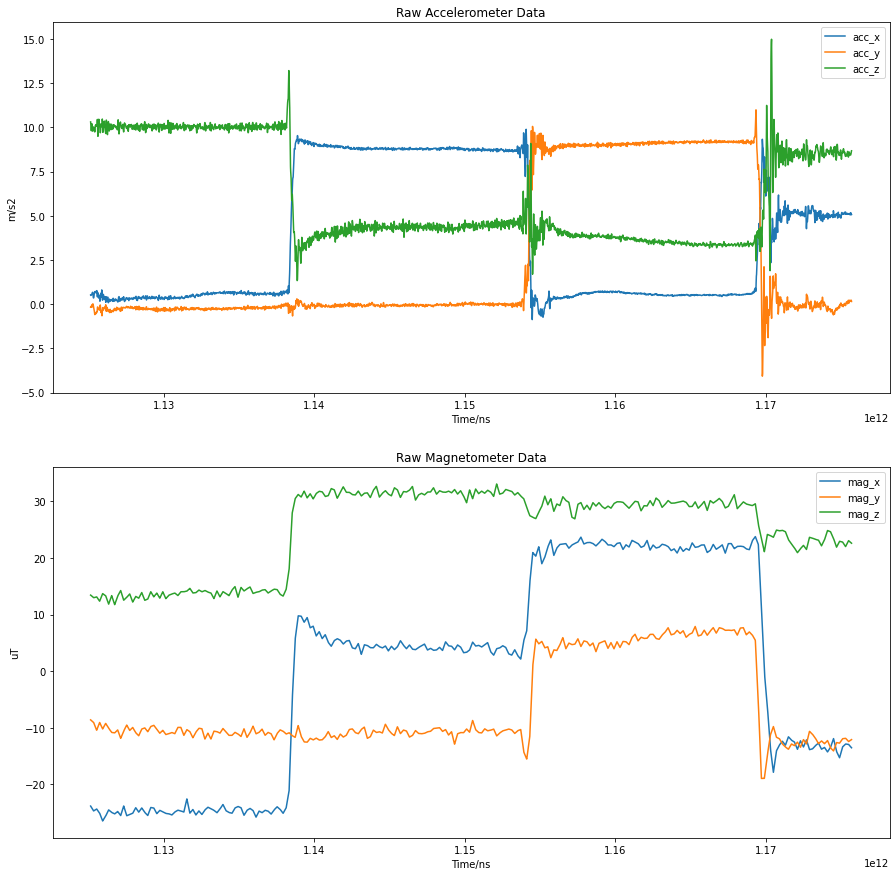

In [2]:
with open("./aggregated.pkl", "rb") as fid:
    data = pickle.load(fid)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))

# Retrieve ACC data.                                                                                                                                                    
ts_ACC = data['ACC'][:,0]  # Timestamps for ACC data.
acc_x = data['ACC'][:,1]
acc_y = data['ACC'][:,2]
acc_z = data['ACC'][:,3]

# Retrieve MAG data.
ts_MAG = data['MAG'][:,0]  # Timestamps for MAG data.
mag_x = data['MAG'][:,1]
mag_y = data['MAG'][:,2]
mag_z = data['MAG'][:,3]

# Orientation results.
ts_ORI = data['ORI'][:,0]  # Timestamps for ORIENTATION data.
pitch_ref = data['ORI'][:,1]
yaw_ref = data['ORI'][:,2]
roll_ref = data['ORI'][:,3]

# Plot ACC data.
ax1.plot(ts_ACC, acc_x)
ax1.plot(ts_ACC, acc_y)
ax1.plot(ts_ACC, acc_z)
ax1.set(xlabel='Time/ns', ylabel='m/s2', title='Raw Accelerometer Data')
ax1.legend(['acc_x', 'acc_y', 'acc_z'])

# Plot MAG data.
ax2.plot(ts_MAG, mag_x)
ax2.plot(ts_MAG, mag_y)
ax2.plot(ts_MAG, mag_z)
ax2.set(xlabel='Time/ns', ylabel='uT', title='Raw Magnetometer Data')
ax2.legend(['mag_x', 'mag_y', 'mag_z'])

## a. Based on the background information in the notebook, work out the orientation i.e. its pitch, roll and yaw from the original accelerometer (ACC) and magnetometer (MAG) data from the pickled file 'aggregated.pkl'. Plot the orientation data in a chart. You may check that your results are correct by comparing it with the reference results in 'pitch', 'roll', and 'yaw'. [5 marks]

### The code below consists of all the helper functions that will be utilized in this notebook. The purpose of each functions are mentioned in the docstrings within the function

In [25]:
def normalize(a, b, c):
    """
    To normalize the values before appending R Matrix
    """
    return 1 / (np.sqrt(((a**2) + (b**2) + (c**2))))


def plotter(ax, x_values, y_values, xlabel, ylabel, title, color):
    """
    Plotting helper function, 
    Takes in the plotting ax, x and y values, labels, title and line color.
    """
    ax.plot(x_values, y_values, color=color)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    

def getRotationMatrix(acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):
    """
    Implement the method needed to get the rotation matrix
    """
    a = np.array(([acc_x], [acc_y], [acc_z]))
    m = np.array(([mag_x], [mag_y], [mag_z]))
    a_cross_m = np.cross(a, m, axis=0)
    a_cross_m_a = np.cross(a_cross_m, a, axis=0)

    col0 = normalize(a_cross_m_a[0], a_cross_m_a[1], a_cross_m_a[2]) * a_cross_m_a
    col1 = normalize(a_cross_m[0], a_cross_m[1], a_cross_m[2]) * a_cross_m
    col2 = normalize(a[0], a[1], a[2]) * a

    R = np.hstack((
        col0,
        col1,
        col2
    ))

    return R

    
def getOrientation(R):
    """
    Implement the method needed to obtain the pitch, roll, and yaw.
    """
    pitch = - np.arcsin(R[0][2])
    yaw = np.arctan2(R[1][2],R[2][2])
    roll = np.arctan2(R[0][1],R[0][0])

    return (pitch, yaw, roll)

In [4]:
calculated_pitch = []
calculated_yaw = []
calculated_roll = []

for i in range(len(acc_x)):
    R = getRotationMatrix(acc_x[i], acc_y[i], acc_z[i], mag_x[i], mag_y[i], mag_z[i])
    (pitch, yaw, roll) = getOrientation(R)
    calculated_pitch.append(pitch)
    calculated_yaw.append(yaw)
    calculated_roll.append(roll)

## Roll

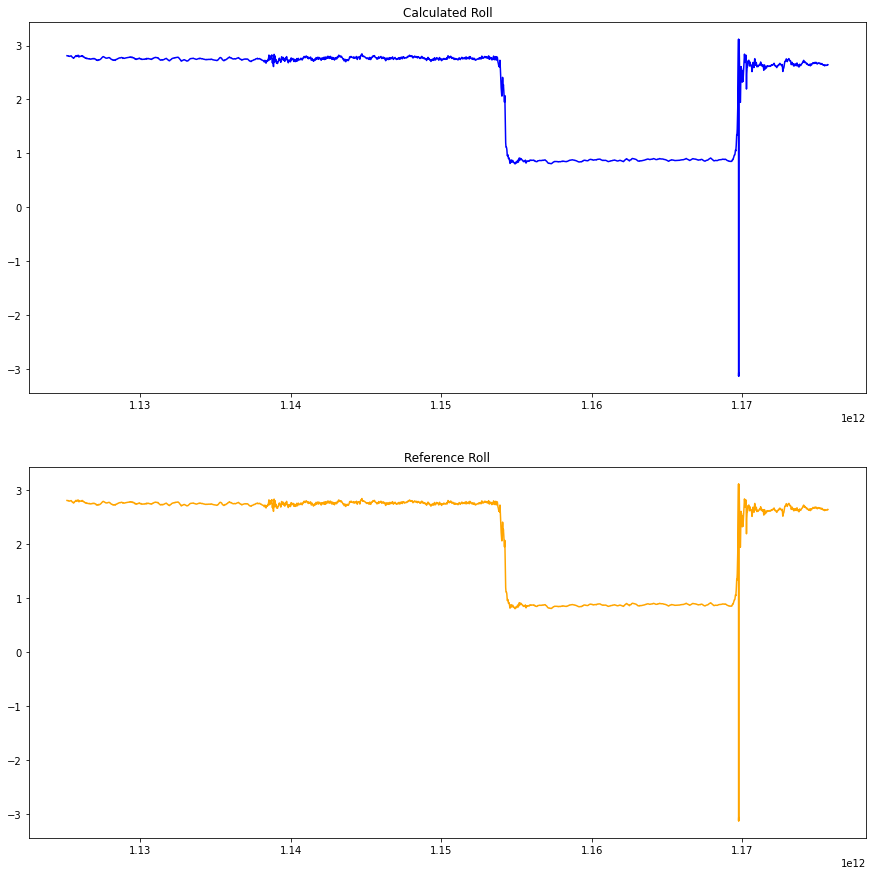

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax1, ts_ORI, calculated_roll, '', '', 'Calculated Roll', 'b')
plotter(ax2, ts_ORI, roll_ref, '', '', 'Reference Roll', 'orange')

## Yaw

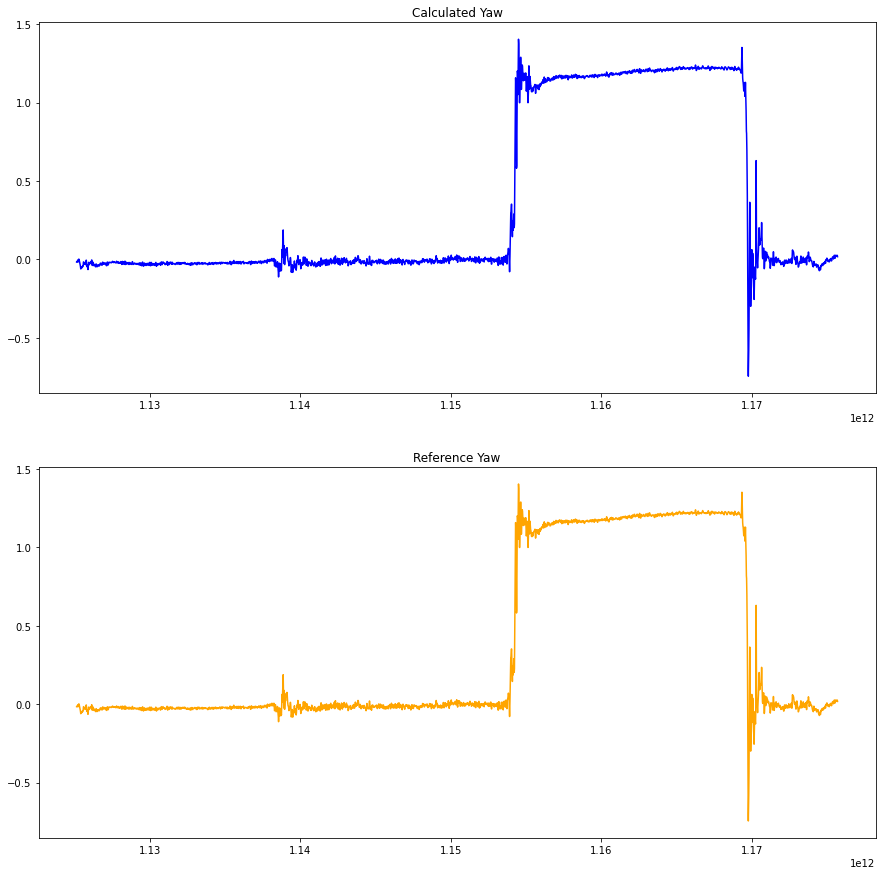

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax1, ts_ORI, calculated_yaw, '', '', 'Calculated Yaw', 'b')
plotter(ax2, ts_ORI, yaw_ref, '', '', 'Reference Yaw', 'orange')

## Pitch

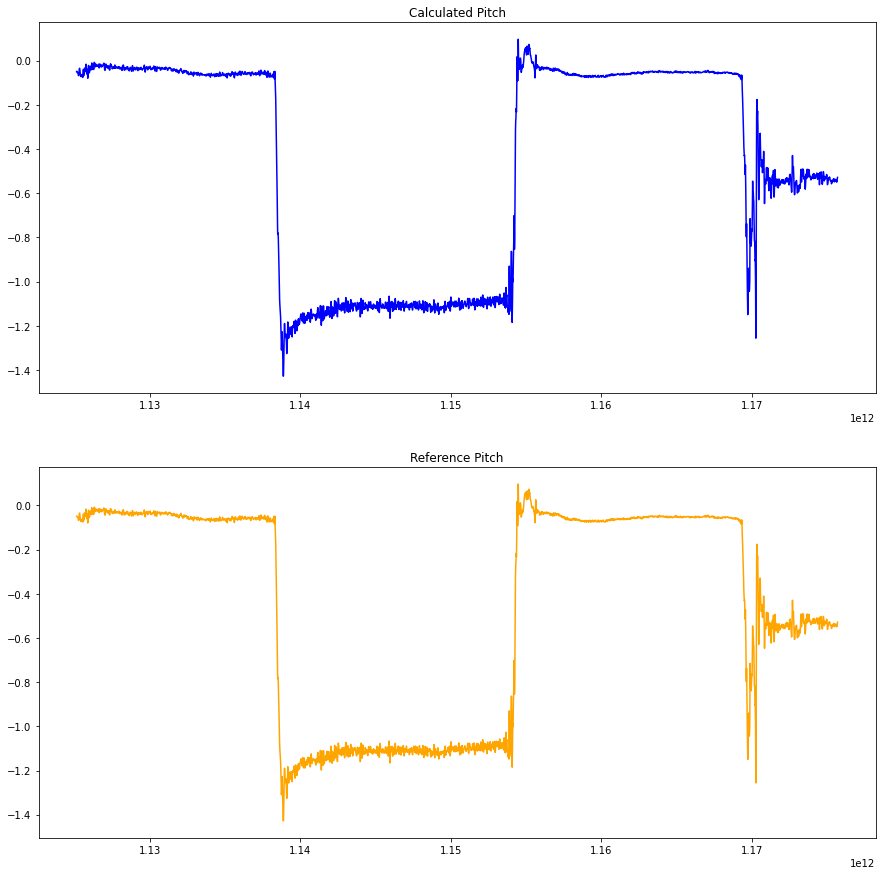

In [11]:
fig, (ax5, ax6) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax5, ts_ORI, calculated_pitch, '', '', 'Calculated Pitch', 'b')
plotter(ax6, ts_ORI, pitch_ref, '', '', 'Reference Pitch', 'orange')

## b. In reality, signals are usually corrupted by different sources of noise such as the electrical mains noise (periodic 50 Hz noise) and radio interference. The file 'synthetic.pkl' contains these noisy signals. Carry out an FFT analysis on the x-axis of the accelerometer in synthetic.pkl to demonstrate the presence of 50 Hz noise. Design a suitable filter to remove the noise as much as possible from the entire dataset and plot the filtered signals in a chart (Do NOT use an FFT filter to solve this problem). [5 marks]

### FFT analysis on acc_x and plotting of spectrum

Frequcies of interest/Hz: [[  0.        ]
 [ 49.98419056]
 [ 50.01053963]
 [199.98946037]
 [200.01580944]] 



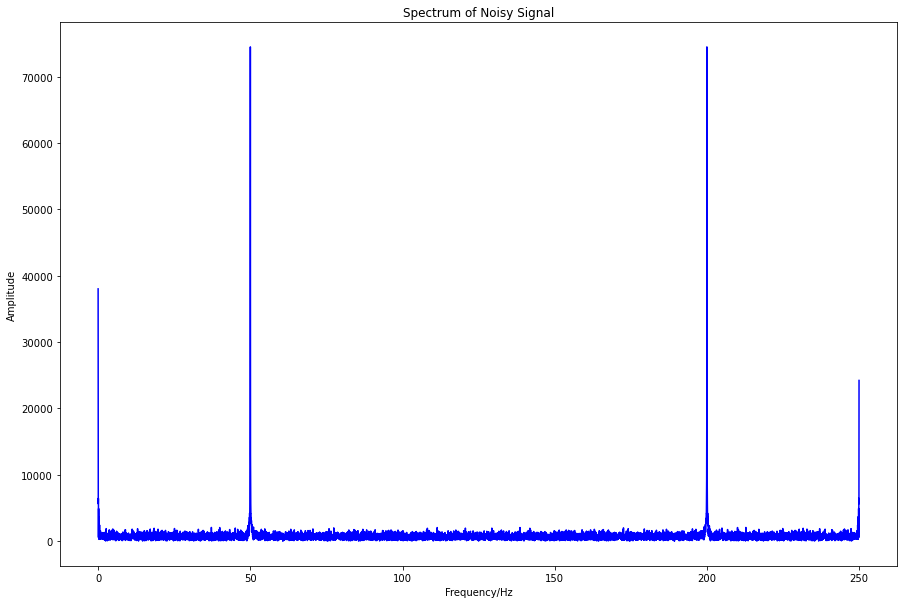

In [13]:
# Unpickle the file 'synthetic.pkl'
with open("synthetic.pkl", "rb") as fid:
    data = pickle.load(fid)

ts_noisy_acc = data['ACC'][:,0]    
noisy_acc_x = data['ACC'][:,1]
noisy_acc_y = data['ACC'][:,2]
noisy_acc_z = data['ACC'][:,3]
noisy_acc = [noisy_acc_x, noisy_acc_y, noisy_acc_z]


ts_noisy_mag = data['MAG'][:,0]  
noisy_mag_x = data['MAG'][:,1]
noisy_mag_y = data['MAG'][:,2]
noisy_mag_z = data['MAG'][:,3]
noisy_mag = [noisy_mag_x, noisy_mag_y, noisy_mag_z]


# Carry out an FFT analysis on the acc_x and plot the spectrum.
sample_freq = 250
frequency = np.arange(len(noisy_acc_x)) * (sample_freq/len(noisy_acc_x))
spectrum=np.abs(fft(noisy_acc_x))

fig, ax = plt.subplots(figsize=(15,10))
plotter(ax, frequency, spectrum, 'Frequency/Hz', 'Amplitude', 'Spectrum of Noisy Signal', 'b')


# Identity location of peaks
threshold= np.max(spectrum)/2.0
indices = np.argwhere( spectrum > threshold)
print('Frequcies of interest/Hz: %s \n' % frequency[indices])

### Design suitable Filter. The filter we are going for is a bandstop filter.

In [14]:
def filter_signal(noisy_signal, sample_freq):
    """
    Takes in a noisy signal and sample frequency to filter noise away with bandstop filter
    The filter used in this function is a bandstop filter between 45Hz to 55Hz
    """
    N = 4
    cutOffHigh = 55.0/(sample_freq/2)
    cutOffLow = 45.0/(sample_freq/2)
    btype = 'bandstop'
    b, a = signal.butter(N, [cutOffLow, cutOffHigh], btype)
    
    return signal.filtfilt(b, a, noisy_signal)    

### Run filter over the dataset 

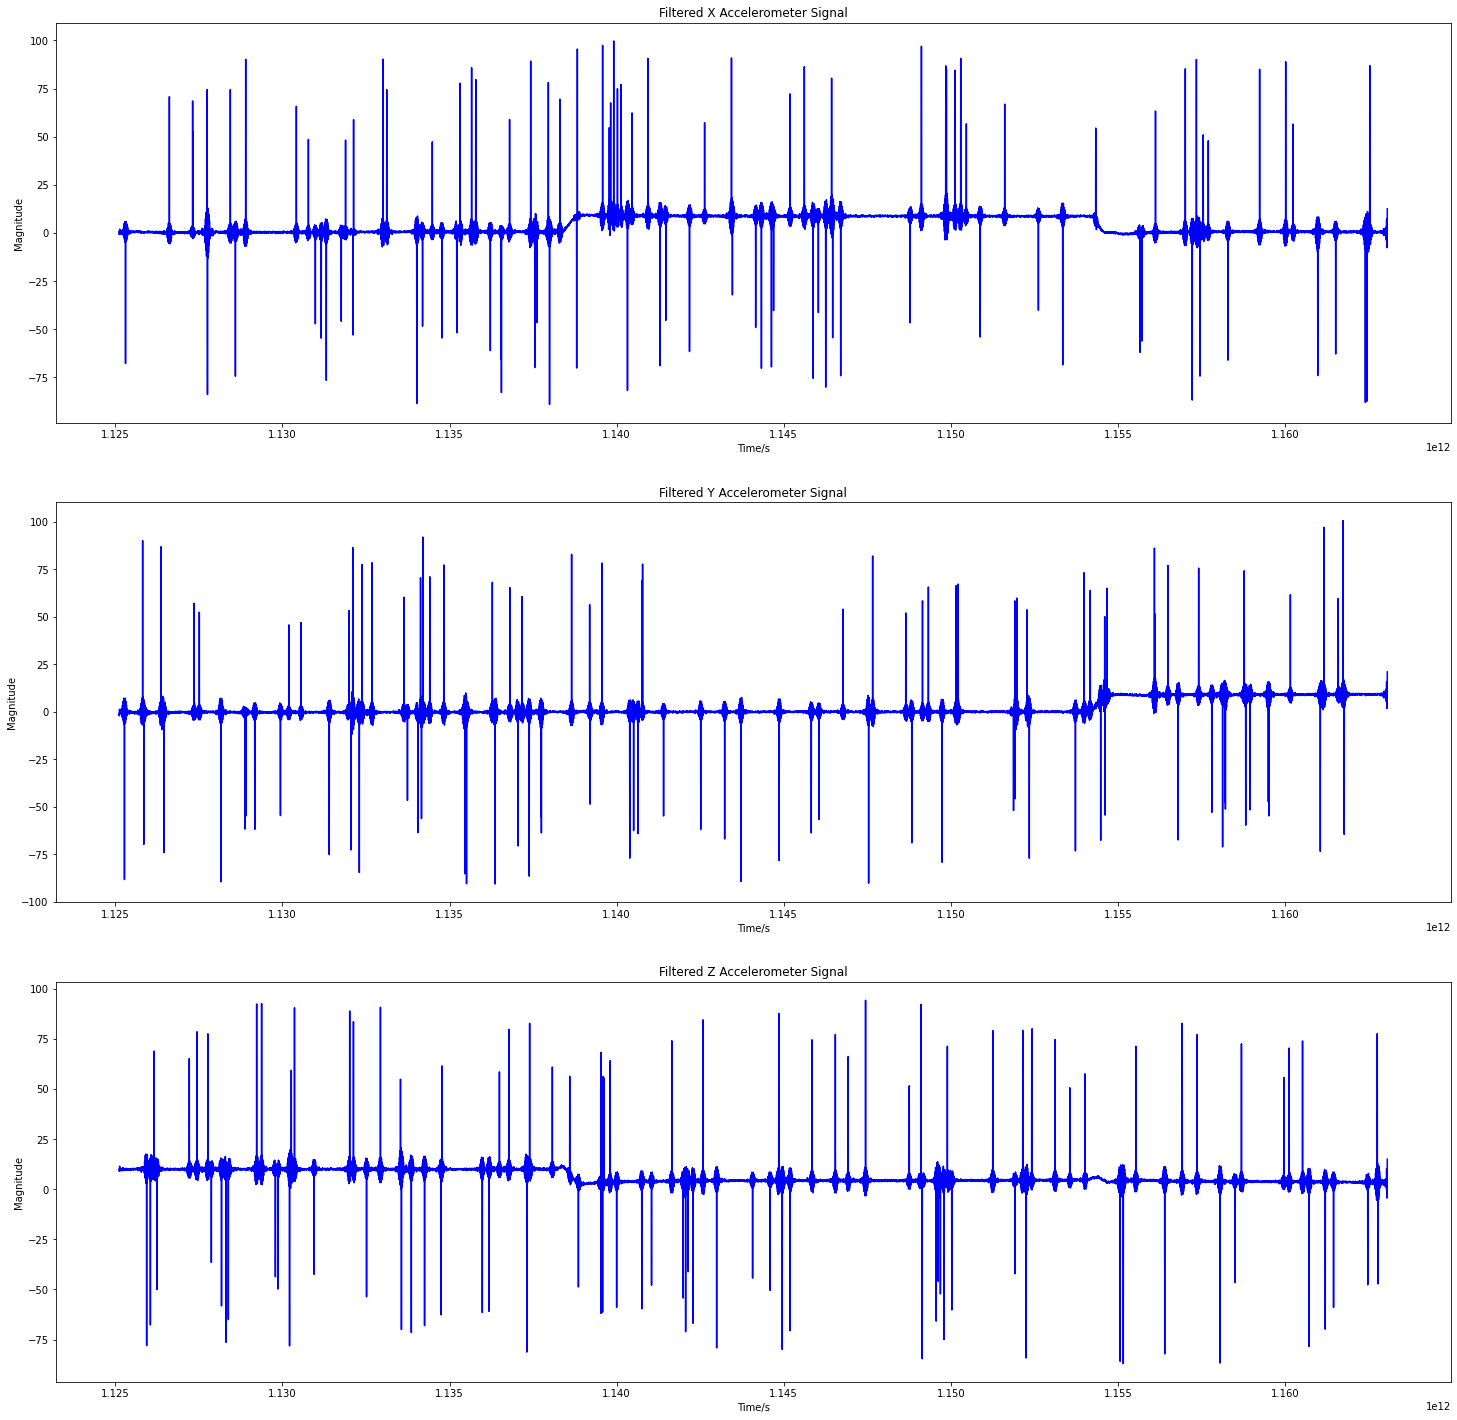

In [15]:
noise_filter_acc = []
noise_filter_mag = []

for n in noisy_acc:
  noise_filter_acc.append(filter_signal(n, sample_freq))

for n in noisy_mag:
  noise_filter_mag.append(filter_signal(n, sample_freq))
  
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25,25))
plotter(ax1, ts_noisy_acc, noise_filter_acc[0], 'Time/s', 'Magnitude', 'Filtered X Accelerometer Signal', color='b')
plotter(ax2, ts_noisy_acc, noise_filter_acc[1], 'Time/s', 'Magnitude', 'Filtered Y Accelerometer Signal', color='b')
plotter(ax3, ts_noisy_acc, noise_filter_acc[2], 'Time/s', 'Magnitude', 'Filtered Z Accelerometer Signal', color='b')

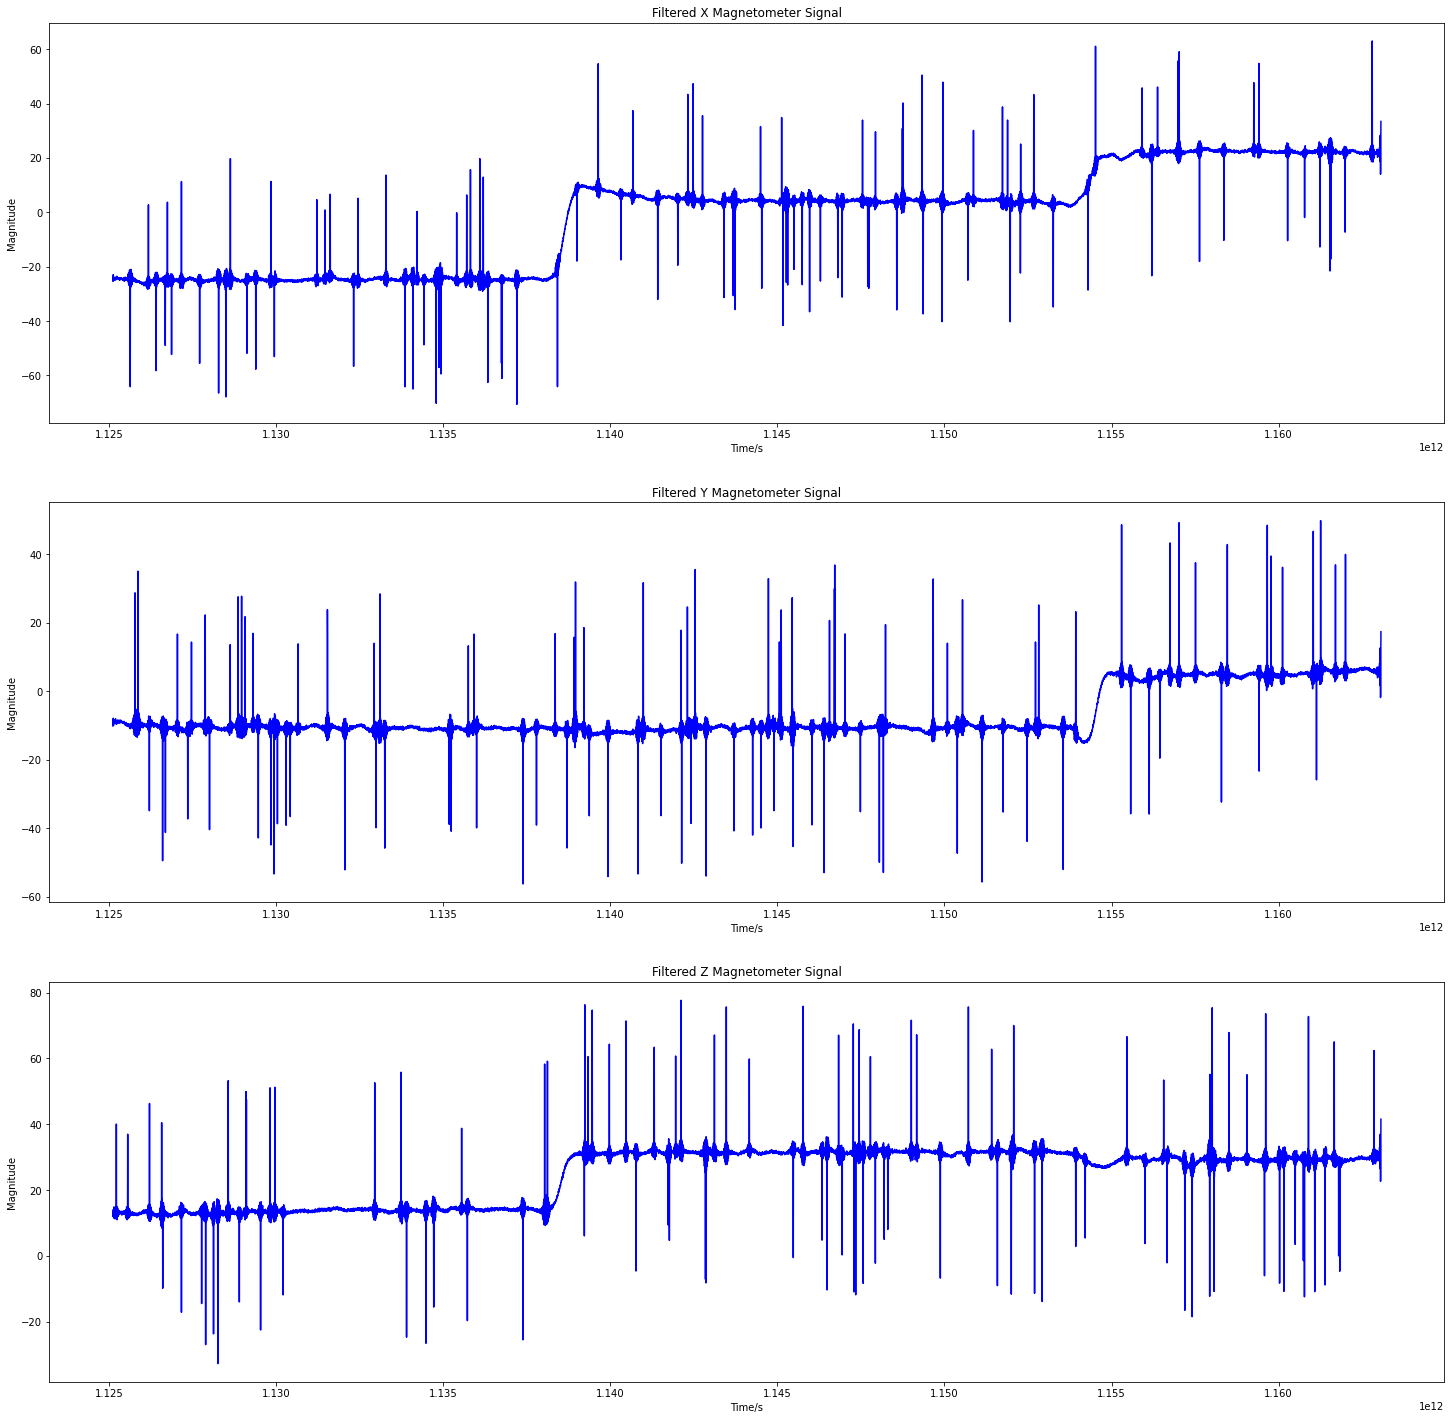

In [16]:
fig, (ax4, ax5, ax6) = plt.subplots(3, 1, figsize=(25,25))

plotter(ax4, ts_noisy_mag, noise_filter_mag[0], 'Time/s', 'Magnitude', 'Filtered X Magnetometer Signal', color='b')
plotter(ax5, ts_noisy_mag, noise_filter_mag[1], 'Time/s', 'Magnitude', 'Filtered Y Magnetometer Signal', color='b')
plotter(ax6, ts_noisy_mag, noise_filter_mag[2], 'Time/s', 'Magnitude', 'Filtered Z Magnetometer Signal', color='b')

## c. Work out the device orientation using your noisy and filtered signals, and plot the signals in order to make comparisons between them, specifically noisy_pitch vs. filtered_pitch, noisy_yaw vs. filtered_yaw, and noisy_roll vs. filtered_roll. [5 marks]

In [17]:
all_noisy_pitch = []
all_noisy_yaw = []
all_noisy_roll = []

for i in range(len(noisy_acc_x)):
    R = getRotationMatrix(
        noisy_acc_x[i], 
        noisy_acc_y[i], 
        noisy_acc_z[i], 
        noisy_mag_x[i], 
        noisy_mag_y[i], 
        noisy_mag_z[i]
    )
    (noisy_pitch, noisy_yaw, noisy_roll) = getOrientation(R)
    all_noisy_pitch.append(noisy_pitch)
    all_noisy_yaw.append(noisy_yaw)
    all_noisy_roll.append(noisy_roll)

filtered_acc_x = filter_signal(noisy_acc_x, sample_freq)
filtered_acc_y = filter_signal(noisy_acc_y, sample_freq)
filtered_acc_z = filter_signal(noisy_acc_z, sample_freq)

filtered_mag_x = filter_signal(noisy_mag_x, sample_freq)
filtered_mag_y = filter_signal(noisy_mag_y, sample_freq)
filtered_mag_z = filter_signal(noisy_mag_z, sample_freq)


all_filtered_pitch = []
all_filtered_yaw = []
all_filtered_roll = []

for i in range(len(noisy_acc_x)):
    R = getRotationMatrix(
        filtered_acc_x[i], 
        filtered_acc_y[i], 
        filtered_acc_z[i], 
        filtered_mag_x[i], 
        filtered_mag_y[i], 
        filtered_mag_z[i]
    )
    (filtered_pitch, filtered_yaw, filtered_roll) = getOrientation(R)
    all_filtered_pitch.append(filtered_pitch)
    all_filtered_yaw.append(filtered_yaw)
    all_filtered_roll.append(filtered_roll)

## Filtered Roll vs Noisy Roll

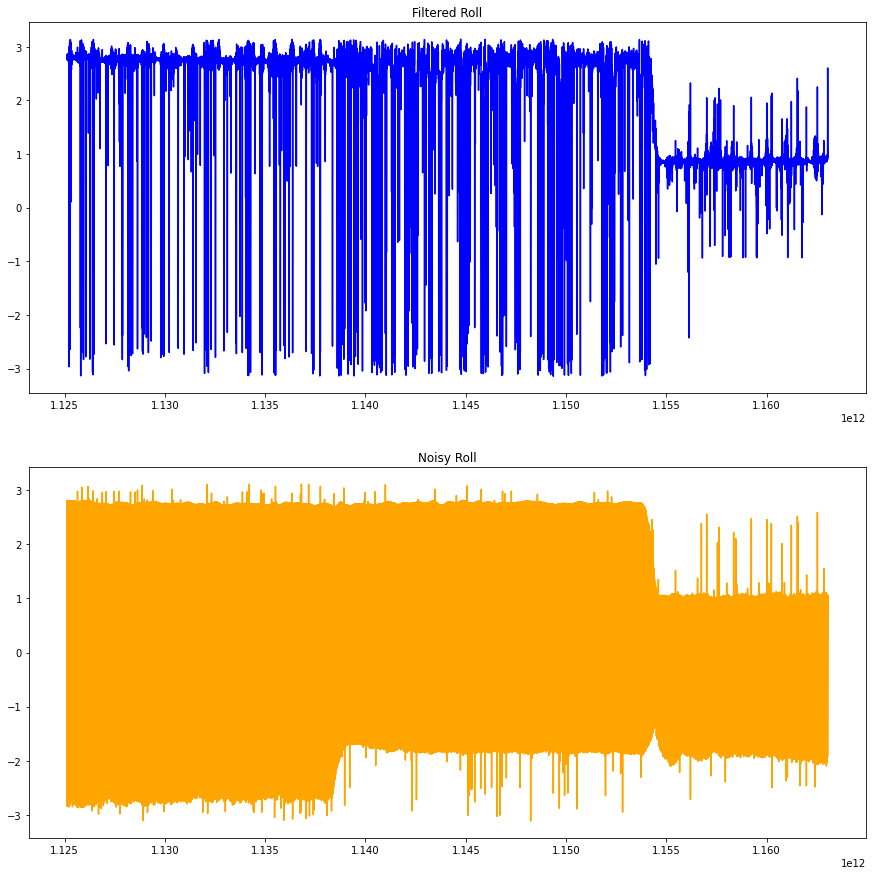

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax1, ts_noisy_acc, all_filtered_roll, '', '', 'Filtered Roll', 'b')
plotter(ax2, ts_noisy_acc, all_noisy_roll, '', '', 'Noisy Roll', 'orange')

## Filtered Yaw vs Noisy Yaw

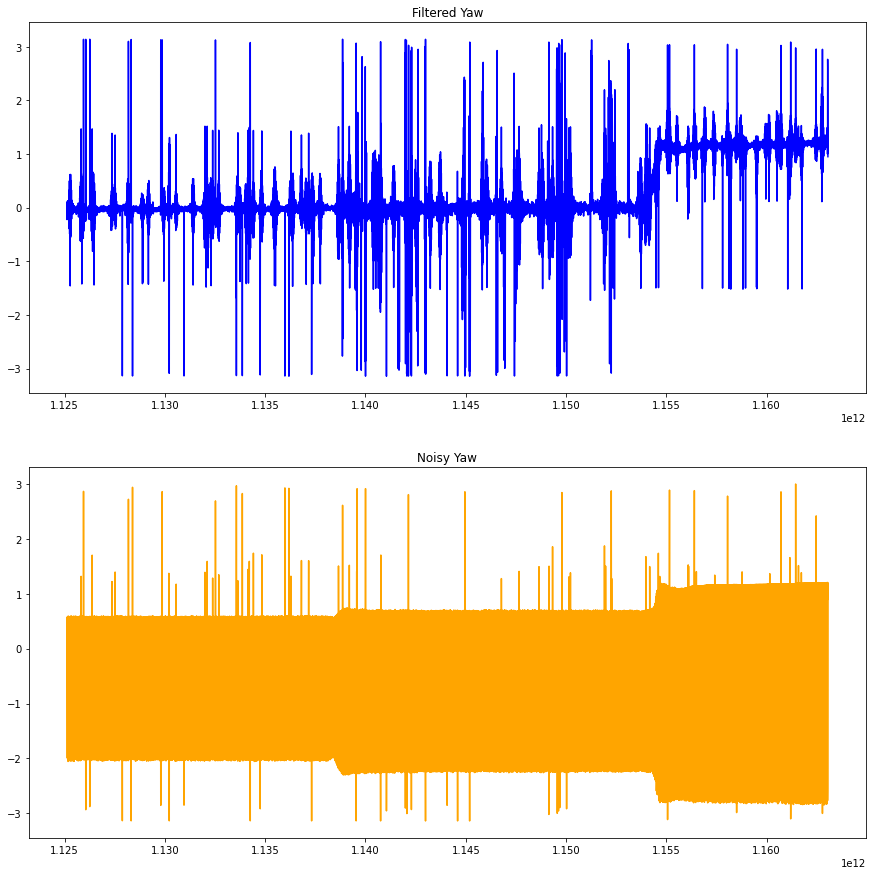

In [19]:
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax3, ts_noisy_acc, all_filtered_yaw, '', '', 'Filtered Yaw', 'b')
plotter(ax4, ts_noisy_acc, all_noisy_yaw, '', '', 'Noisy Yaw', 'orange')

## Filtered Pitch vs Noisy PItch

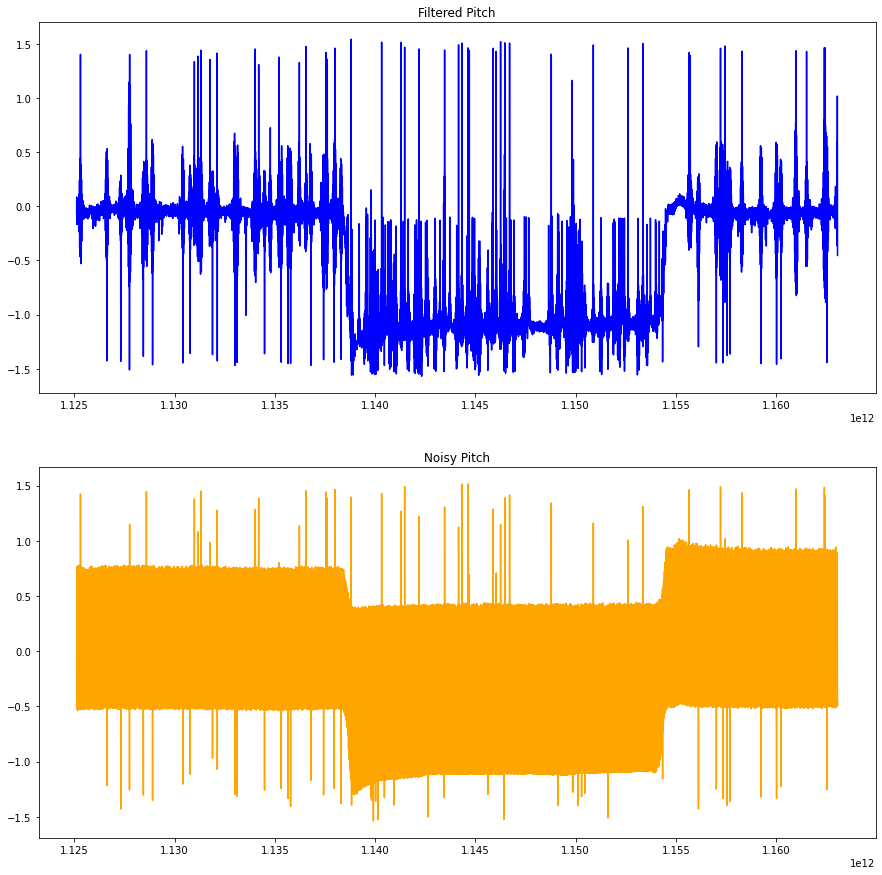

In [20]:
fig, (ax5, ax6) = plt.subplots(2, 1, figsize=(15,15))
plotter(ax5, ts_noisy_acc, all_filtered_pitch, '', '', 'Filtered Pitch', 'b')
plotter(ax6, ts_noisy_acc, all_noisy_pitch, '', '', 'Noisy Pitch', 'orange')

## d. Identify the second source of noise from your earlier plot and design a second stage filter in order to improve the signal quality. Re-plot the signals to demonstrate improvements. [5 marks]

### Implementation of second filter. The filter we are using is a moving median average filter.

In [21]:
def median_filter(input_signal, window_sz=3):
    result = np.zeros(len(input_signal))
    
    result[:window_sz] = np.mean(input_signal[:window_sz])
    index=window_sz
    while index<len(input_signal):
        l = index-window_sz+1
        window = input_signal[l:(index+1)]
        median_val = np.median(window)
        result[index] = median_val
        index += 1
    
    return result

median_average_filtered_acc = []
median_average_filtered_mag = []

for n in noise_filter_acc:
  median_average_filtered_acc.append(median_filter(n,32))
for n in noise_filter_mag:
  median_average_filtered_mag.append(median_filter(n,32))

## Median Averaged Filtered Roll vs Filtered Roll

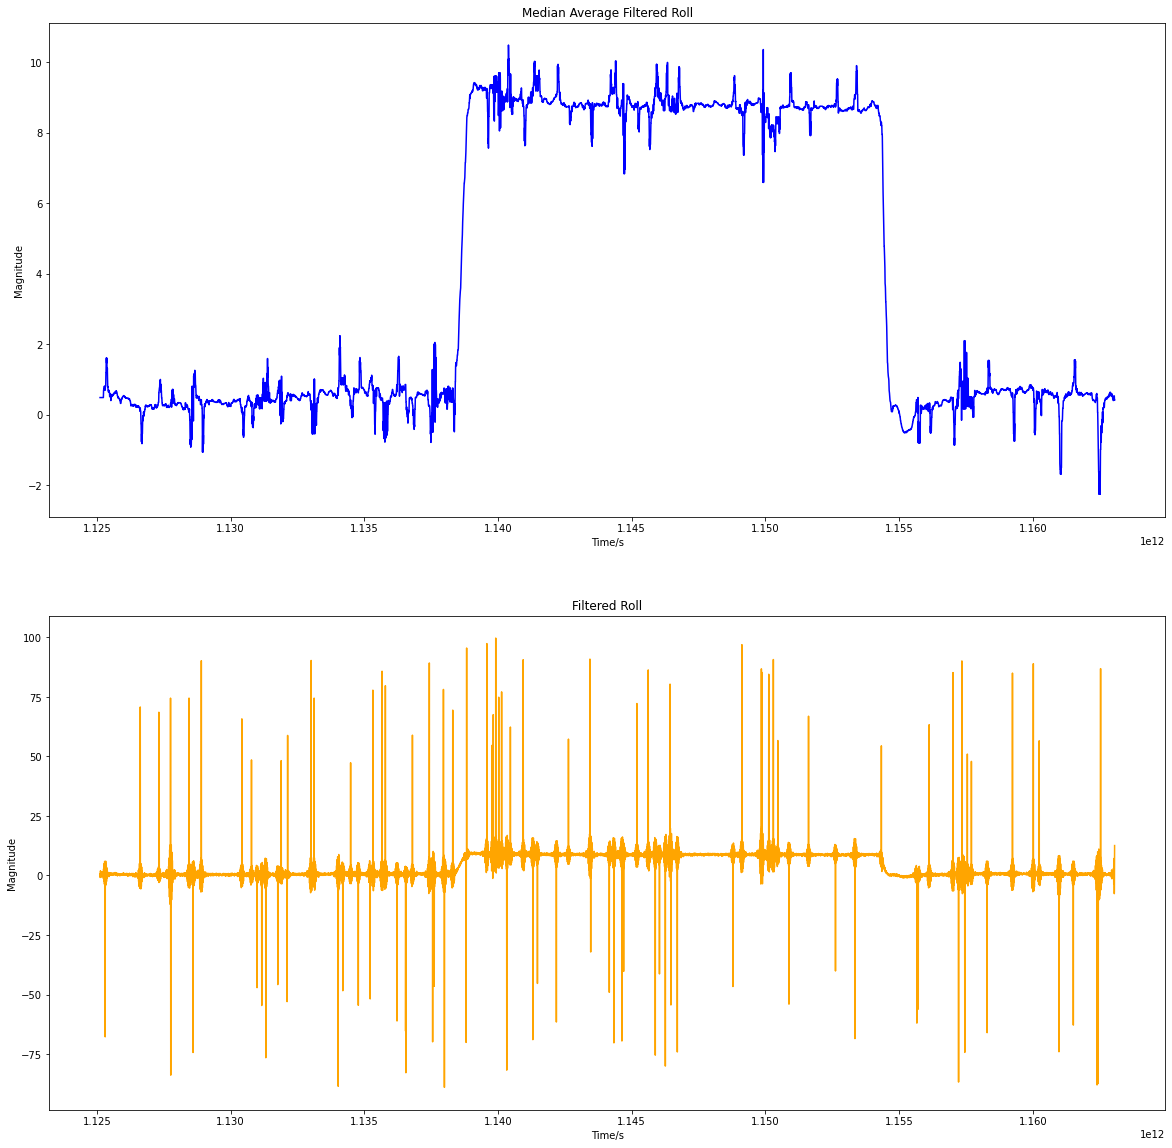

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))
plotter(ax1, ts_noisy_acc, median_average_filtered_acc[0], 'Time/s', 'Magnitude', 'Median Average Filtered Roll', color='b')
plotter(ax2, ts_noisy_acc, noise_filter_acc[0], 'Time/s', 'Magnitude', 'Filtered Roll', color='orange')

## Median Averaged Filtered Yaw vs Filtered Yaw

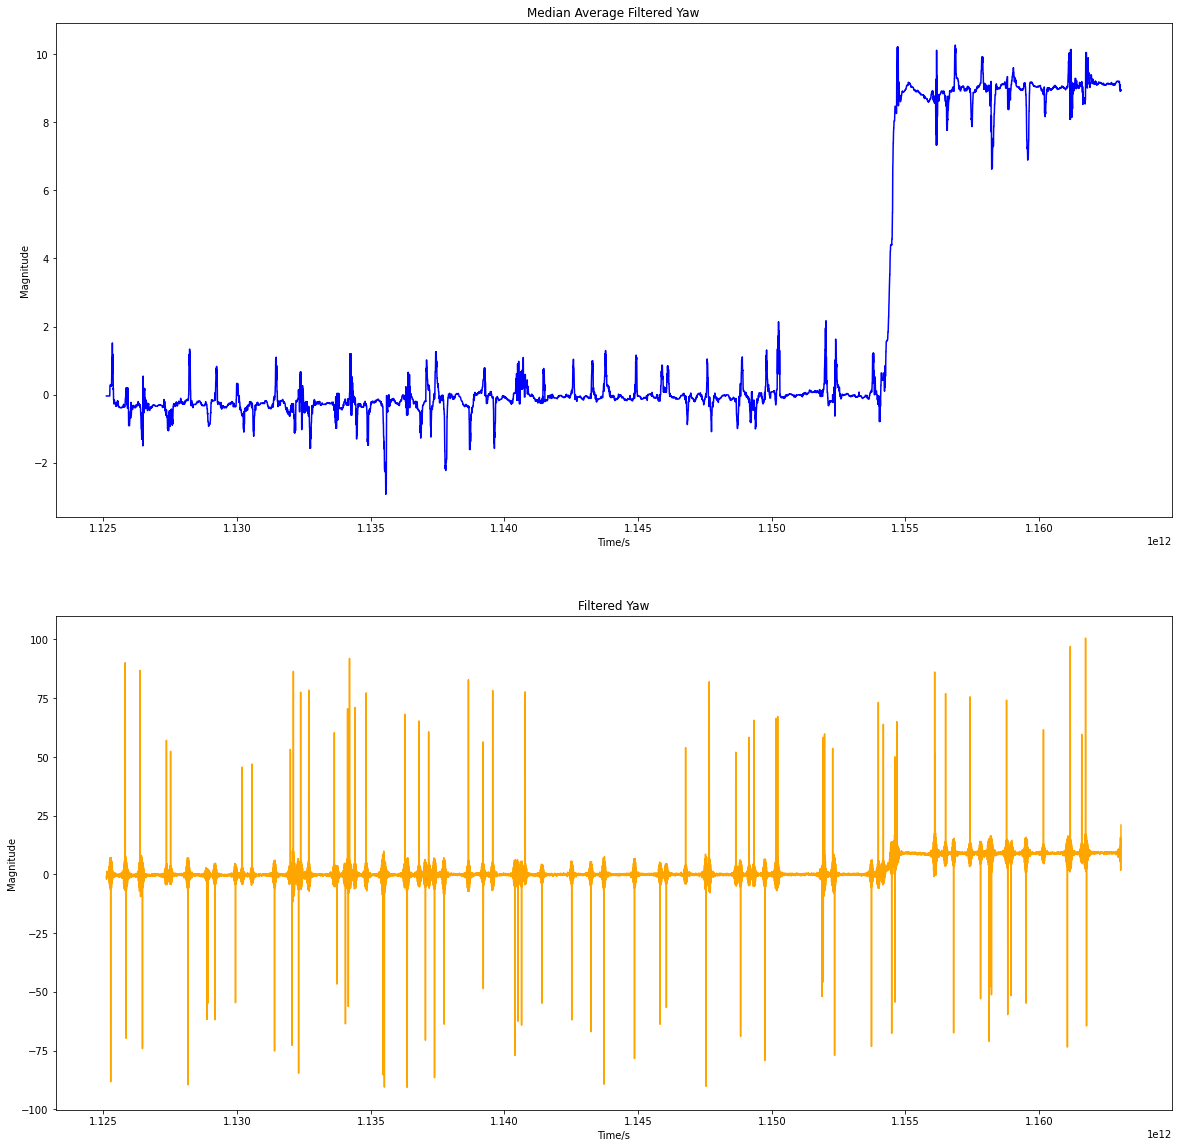

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))
plotter(ax1, ts_noisy_acc, median_average_filtered_acc[1], 'Time/s', 'Magnitude', 'Median Average Filtered Yaw', color='b')
plotter(ax2, ts_noisy_acc, noise_filter_acc[1], 'Time/s', 'Magnitude', 'Filtered Yaw', color='orange')

## Median Averaged Filtered Pitch vs Filtered Pitch

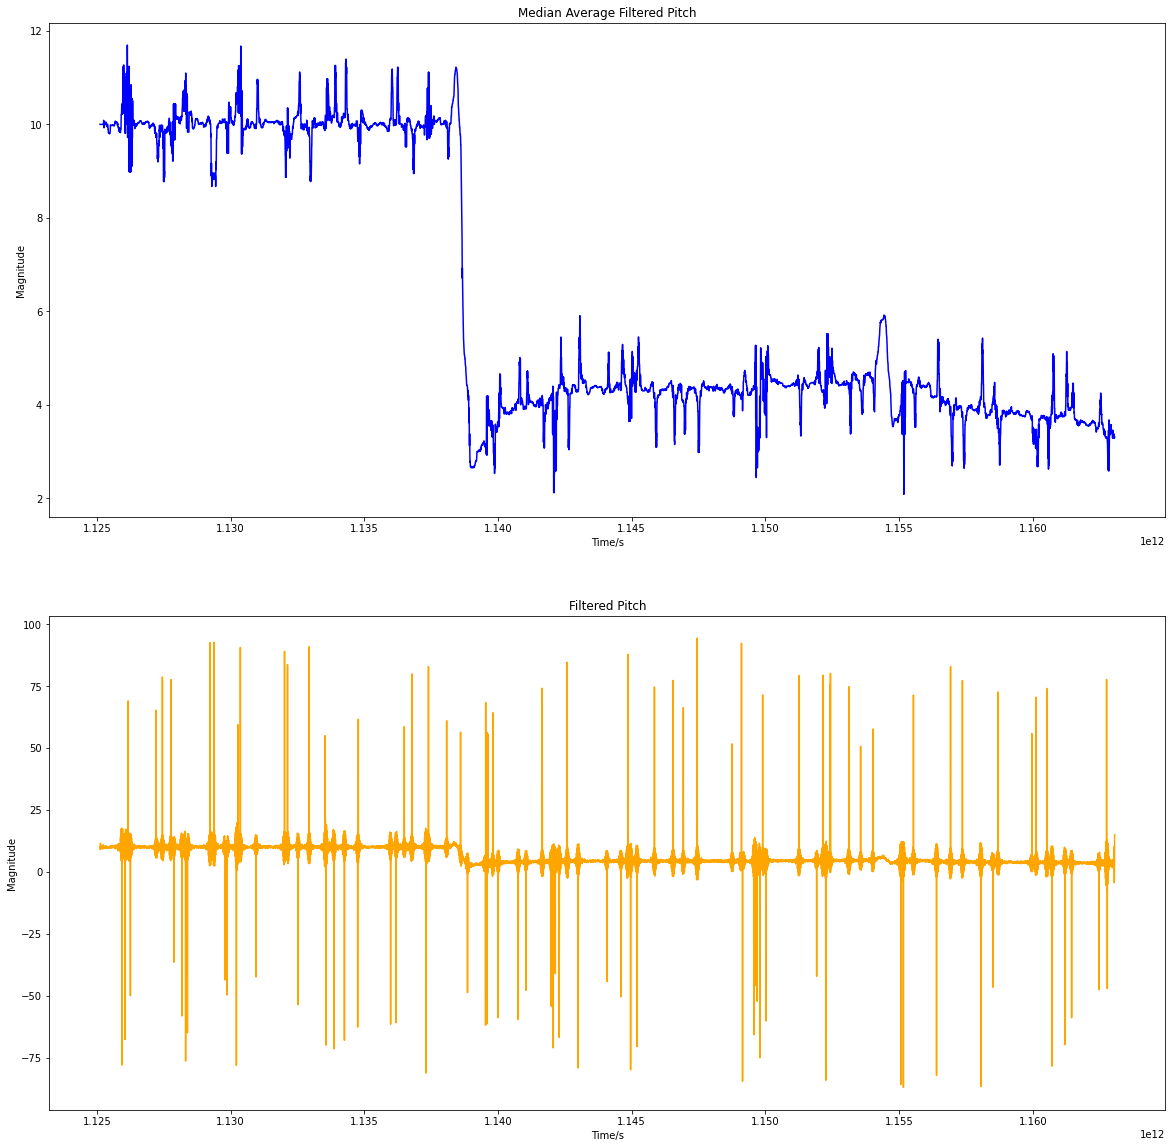

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))
plotter(ax1, ts_noisy_acc, median_average_filtered_acc[2], 'Time/s', 'Magnitude', 'Median Average Filtered Pitch', color='b')
plotter(ax2, ts_noisy_acc, noise_filter_acc[2], 'Time/s', 'Magnitude', 'Filtered Pitch', color='orange')